<a href="https://colab.research.google.com/github/tuxsy/iebs-master-data-science/blob/main/m06/c3/sprint/Sprint3_Bruno_AnglesRobles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datos del alumno

**Nombre**: Bruno


**Apellidos**: Anglés Robles


**Grupo:** B2

# Introducción

El cliente ya se encuentra más cómodo con la explicación que le hemos aportado con los árboles de decisión, y nos ha solicitado continuar por esa vía, intentando mejorar los resultados. Para ello vamos a emplear los métodos de ensemble que utilicen como modelo base los árboles de decisión.

**Concretamente se pide:**

- Aplicar al menos dos tipos diferentes de ensemble (uno de Bagging y otro de Boosting) de los vistos en clase, empleando como modelo base los árboles de decisión y probando con dos configuraciones de hiperparámetros diferentes para cada tipo de ensemble elegido.
- Comparar y discutir los resultados, identificando el mejor ensemble en cuanto a poder predictivo.
- Obtención de las variables más relevantes del modelo. ¿Tiene sentido que sean las variables con mayor peso?
- PARTE OPCIONAL: utiliza para algún método de ensemble que lo permita (AdaBoostClassifier, BaggingClassifier, etc.)  un modelo base diferente a los árboles de decisión y estudiar la influencia que tiene en los resultados, así como en la varianza y sesgo.


Este cuaderno es una continuación del que se desarrolló en los sprints 1 y 2

- Enlace Google Colab: [Sprint 1](https://colab.research.google.com/drive/1E_PXauQA95SVK2Y19QILm8avfqGFdm9U?usp=sharing), [Sprint 2](https://colab.research.google.com/drive/1GAhs1dnr50ULcBYIsxMbl3vgw5CgRItz?usp=share_link)
- Enlace Github: [Sprint 1](https://github.com/tuxsy/iebs-master-data-science/blob/main/m06/c1/sprint/Sprint1_Bruno_AnglesRobles.ipynb), [Sprint 2](https://github.com/tuxsy/iebs-master-data-science/blob/main/m06/c2/sprint/Sprint2_Bruno_Angl%C3%A9sRobles_ipynb.ipynb)


# Preparación

In [1]:
# IMPORTACIÓN DE LIBRERÍAS

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import style
from sklearn.model_selection import train_test_split # Importamos función train_test_split 
from sklearn import metrics #Importamos métricas del módulo de scikit-learn para calcular lel accuracy del modelo
# style.use('ggplot') or plt.style.use('ggplot')
from IPython.display import display
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# CARGA DE DATOS
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1ZwgdmI525zInDh1SQVm7FZt8kWxfrvOK' -O 'Rotacion_empleados.csv'
datos = pd.read_csv("Rotacion_empleados.csv")
# El dataset contiene una varialbe llamada "sales" que debemos renombrar a "department"
datos = datos.rename(columns={"sales": "department"})
datos.head()

--2023-02-22 18:25:18--  https://drive.google.com/uc?export=download&id=1ZwgdmI525zInDh1SQVm7FZt8kWxfrvOK
Resolving drive.google.com (drive.google.com)... 142.251.111.138, 142.251.111.139, 142.251.111.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.111.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qgs2l4b4j83vbv90p094lj495rgmj77h/1677090300000/14644984037434537262/*/1ZwgdmI525zInDh1SQVm7FZt8kWxfrvOK?e=download&uuid=99408fc9-9e23-4454-94fc-c0c8961035e7 [following]
--2023-02-22 18:25:18--  https://doc-08-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qgs2l4b4j83vbv90p094lj495rgmj77h/1677090300000/14644984037434537262/*/1ZwgdmI525zInDh1SQVm7FZt8kWxfrvOK?e=download&uuid=99408fc9-9e23-4454-94fc-c0c8961035e7
Resolving doc-08-b0-docs.googleusercontent.com (doc-08-b0-docs.googleusercontent.com)... 142.251.163.132, 

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# COPIA DE SEGURIDAD
datos_orig = datos.loc[:,:]

En este caso la variable a predecir es left: `{1: abandonó, 0: no abandonó}`.

Los datos contienen dos variables categóricas: `department, salary`. Que vamos a tener que transformar a numéricas.

- Usaré la técnica de OneHotEncoding para `department` ya que esta variable no está ordenada.
- La variable `salary` la transformaré manualmente según el orden: `{1: low, 2: medium, 3: high}`.

In [4]:
# Transformación de la variable categórica "department"

print("Before:", datos.loc[:10, "department"].values)

datos = (
    pd.get_dummies(
        datos, 
        columns=["department"],
        )
    )

print("After:", datos.loc[:10, [c for c in datos.columns if "department" in c]].values)

Before: ['sales' 'sales' 'sales' 'sales' 'sales' 'sales' 'sales' 'sales' 'sales'
 'sales' 'sales']
After: [[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]]


In [5]:
# Transformación de la variable categórica "salary"
print("Before:", set(datos.salary))
datos.salary = datos.salary.map({"low": 1, "medium": 2, "high":3})
print("After:", set(datos.salary))

Before: {'high', 'low', 'medium'}
After: {1, 2, 3}


# Análisis exploratorio

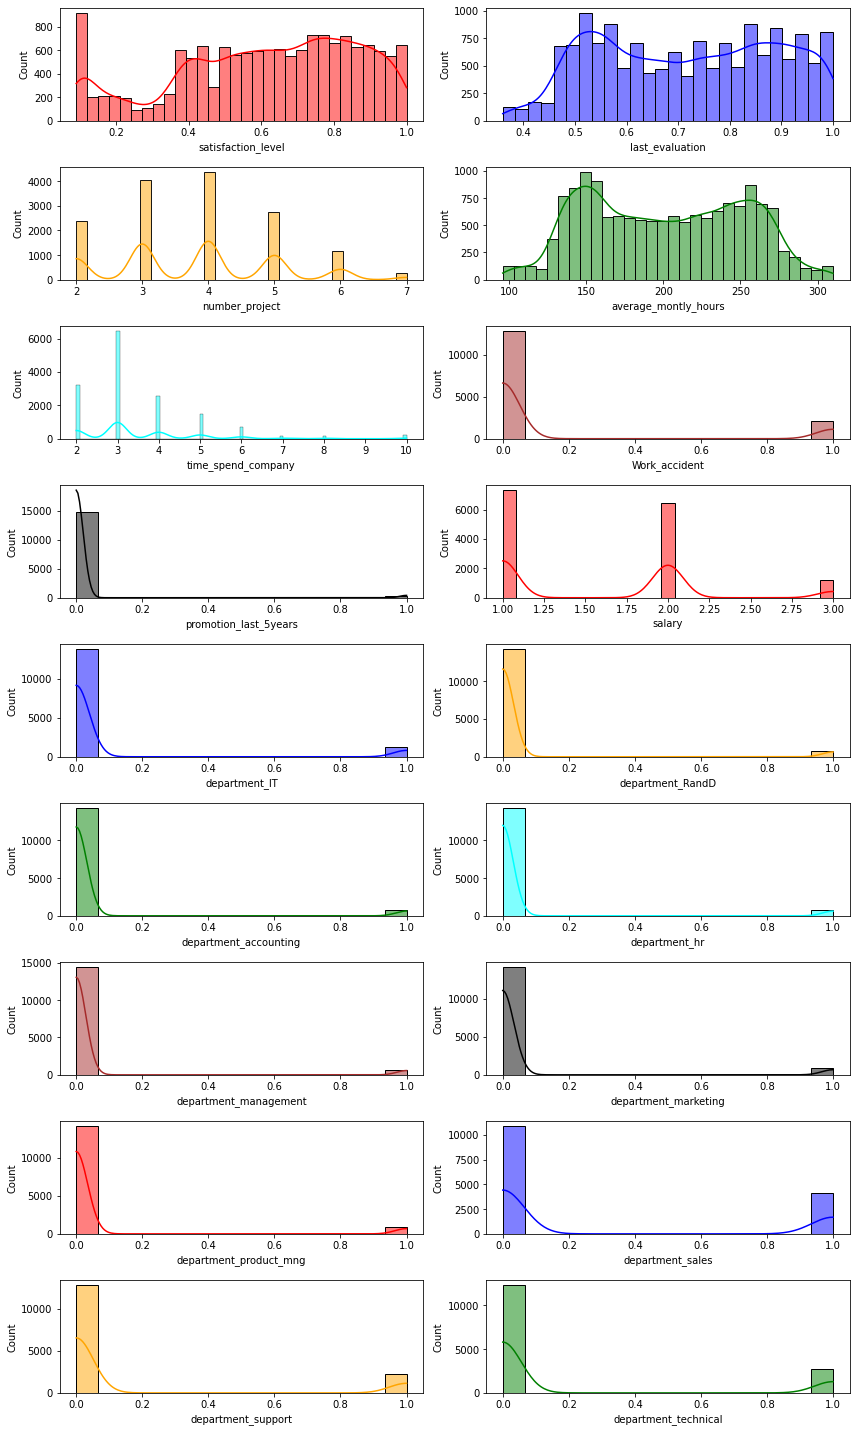

In [6]:
# Mostramos los histogramas de las variables explicativas
features = datos.columns[datos.columns != "left"]
colors = ["red", "blue", "orange", "green", "cyan", "brown", "black"]

cols = 2
rows = int(np.ceil(len(features) / cols))
f, axes = plt.subplots(rows, cols, figsize=(12, 20))
for i, var in enumerate(features):
  a = int(np.floor(i / cols))
  b = int(i % cols)
  c = colors[i % len(colors)]
  sns.histplot(datos[var], color=c, ax=axes[a, b] , kde=True)

plt.tight_layout()

La mayoría de variables son discretas y están en el rango `[0. 1]`. Hay algunas variables discretas con un rango distinto y otras son contínuas.

Como los métodos de *Bagging* y *Boosting* van a estar basados en árboles de decisión no necesitaremos transformar las variables.

Voy a centrarme ahora en la variable a predecir (`left`)

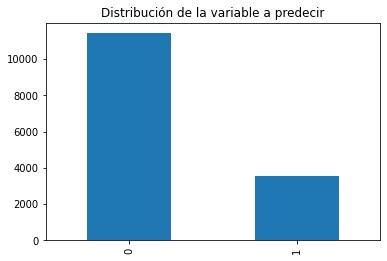

0    11428
1     3571
Name: left, dtype: int64


In [7]:
# Mostramos la distribución de la variable a predecir

value_counts = datos.left.value_counts()
plt.title("Distribución de la variable a predecir")
value_counts.plot(kind="bar")
plt.show()
print(value_counts)

Vemos que tenemos un problema de desbalanceo. Hay más casos de "no abandono" que de "abandono". Esto puede representar un problema con los árboles de decisión.

Para abordar este problema voy a usar la técnica de *Cross Validation*, concretamente mediante *Stratified KFold*.

# Muestreo

En esta sección no vamos a hacer la típica separación entre *train* y *test*, eso se lo dejamos *StratifiedKFold*.

La separación entre *train* y *test* se hará a la hora de entrenar cada modelo según las particiones de datos que determine el algoritmo.

In [8]:
# Separamos el conjunto de datos en features (X) y target (y)
X = datos.loc[:, datos.columns != "left"].values
y = datos.loc[:, datos.columns == "left"].values.flatten()

In [9]:
# Instanca de StratifiedKFold que reutilizaremos a lo largo del cuaderno
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 42)



# Entrenamiento algoritmo de Bagging

Como algoritmo de *bagging* usaremos un **Random Forest**. 

Como en el sprint pasado ya entrenamos árboles de decisión sabemos a partir de qué profundidad éstos empiezan a sobreentrenar. Usaremos esta información para limitar la profundidad máxima de nuestros árboles.

Para la primera selección de hiperparámetros empezaremos con la profundidad en la que entrenamos el árbol de decisión en el sprint pasado.

In [10]:
# Especificamos el primer hiperparámetro con el que vamos a entrenar
max_depth = 4

# No nos importa entrenar árboles más profundos siempre que no sobrepasemos
#   la profundidad a la que sabemos que éstos empiezan a sobreentrenar.
max_depth_range = np.arange(4, 10)

## Primer conjunto de hiperparámetros

In [11]:
# ENTRENAMIENTO DE RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier


rf_1 = RandomForestClassifier(
    max_depth = max_depth,
    n_estimators=100, n_jobs=-1, random_state=42)
print("RandomForest #1:", rf_1)
print()


train_scores_rf_1 = []
test_scores_rf_1 = []

start = time.time()
for train_index, test_index in skf.split(X, y):
    X_train = datos.iloc[train_index].loc[:, features]
    X_test = datos.iloc[test_index].loc[:,features]
    y_train = datos.iloc[train_index].loc[:,'left']
    y_test = datos.loc[test_index].loc[:,'left']

    rf_1.fit(X_train, y_train) #Training the model

    # Save train / test scores
    train_scores_rf_1.append(rf_1.score(X_train, y_train))
    test_scores_rf_1.append(rf_1.score(X_test, y_test))
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
print()

acc_mean_rf_1 = np.mean(test_scores_rf_1)
acc_mean_rf_1_train = np.mean(train_scores_rf_1)
print(f"Train score for Random Forest: mean={acc_mean_rf_1_train:.4f}, std={np.std(train_scores_rf_1):.6f}")
print(f"Test score for Random Forest: mean={acc_mean_rf_1:.4f}, std={np.std(test_scores_rf_1):.6f}")
print()

# Use cross_val_predict to get predicted labels
y_pred_rf_1 = cross_val_predict(rf_1, X, y, cv=skf)

# Calculate the bias and variance
bias_rf_1 = np.abs(y - y_pred_rf_1).mean()
variance_rf_1 = acc_mean_rf_1 - bias_rf_1
print("Bias:", "%.3f" % bias_rf_1)
print("Variance:", "%.3f" % variance_rf_1)
print()

# Print confussion matrix
conf_matrix_rf_1 = metrics.confusion_matrix(y_true=y, y_pred=y_pred_rf_1)
print("Confussion Matrix:")
print(conf_matrix_rf_1)
print()

# Print classification report
clf_report_rf_1 = metrics.classification_report(y_true=y, y_pred=y_pred_rf_1)
print("Classification report:")
print(clf_report_rf_1)
print()



RandomForest #1: RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=42)

Tiempo empleado: 6.80 segundos

Train score for Random Forest: mean=0.9185, std=0.000464
Test score for Random Forest: mean=0.9183, std=0.001490

Bias: 0.082
Variance: 0.837

Confussion Matrix:
[[11369    59]
 [ 1166  2405]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11428
           1       0.98      0.67      0.80      3571

    accuracy                           0.92     14999
   macro avg       0.94      0.83      0.87     14999
weighted avg       0.92      0.92      0.91     14999




El accuracy es prácticamente igual para *train* que para *test*, es posible que este modelo esté sub-entrenado.

El pasado sprint vimos que para este problema nos interesa fijarnos en el *recall* de la clase positiva. Según está métrica este modelo es muy mejorable.

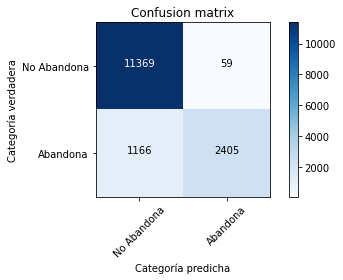

In [12]:
# Mostramos la matriz de confusión de una forma más estética
import itertools
def plot_confusion_matrix(cm, classes=["No Abandona", "Abandona"],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta función imprime y representa la matriz de confusión
    Puede aplicarse la normalización de la matriz con el parámetro `normalize=True`.
    """
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Matriz de confusión normalizada")
    # else:
    #     print('Matriz de confusión sin normalización')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Categoría verdadera')
    plt.xlabel('Categoría predicha')
    plt.tight_layout()

plot_confusion_matrix(conf_matrix_rf_1)

La matriz de confusión nos muestra la gran cantidad de errores que el modelo ha cometido al clasificar los casos que *Abandonan*.

Voy a entrenar con un segundo conjunto de hiperparámetros.

## Segundo conjunto de hiperparámetros

Primero que nada voy a echar un vistazo a los hiperparámetros del primer modelo y seleccionaré algunos que me parezcan interesantes para probar.

Para seleccionar unos nuevos hiperparámetros combinaré *RandomSearch* con *GridSearch*. En ambos casos me apoyaré en la instancia de *StratifiedKFold* que hemos creado antes para la validación cruzada.

In [13]:
# ¿Con qué hiperparámetros hemos entrenado el modelo anterior?

print("Hiperparameters:")
rf_1.get_params()

Hiperparameters:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [14]:
# BUSCAR LOS MEJORES HIPERPARÁMETROS PARA RANDOM FOREST
# RandomSearch

from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf = RandomForestClassifier(random_state=42)


rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 10, 
    cv = skf.split(X, y), 
    verbose=2, 
    random_state=42, 
    n_jobs = -1,
    scoring="accuracy"
)

start = time.time()
rf_random.fit(X, y)
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
cv_res = rf_random.cv_results_
print(
    "Accuracy for Random Forest (Random Search):",
    f"mean={cv_res['mean_test_score'].mean():.4f},", 
    f"std={cv_res['std_test_score'].mean():.6f}"
)
rf_random_best_params = rf_random.best_params_
rf_random_best_params

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tiempo empleado: 98.62 segundos
Accuracy for Random Forest (Random Search): mean=0.9862, std=0.001628


{'n_estimators': 211,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'bootstrap': False}

In [15]:
# BUSCAR LOS MEJORES HIPERPARÁMETROS PARA RANDOM FOREST
# GridSearch
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
min_samples_leaf = rf_random_best_params['min_samples_leaf']
min_samples_split = rf_random_best_params['min_samples_split']

n_estimators = rf_random_best_params['n_estimators']

param_grid = {
    'bootstrap': [rf_random_best_params['bootstrap']],
    'max_depth': max_depth_range,
    'max_features': [rf_random_best_params['max_features']],
    'min_samples_leaf': np.arange(max(1, min_samples_leaf-1), min_samples_leaf+2),
    'min_samples_split': np.arange(max(2, min_samples_split-1), min_samples_split+2),
    'n_estimators': [(n_estimators - 10), n_estimators, (n_estimators + 10)]
}

# Create a based model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
rf_grid = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid, 
    cv = skf.split(X,y), 
    n_jobs = -1, 
    verbose = 2
)
start = time.time()
rf_grid.fit(X, y)
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
cv_res = rf_grid.cv_results_
print(
    "Accuracy for Random Forest (Grid Search):",
    f"mean={cv_res['mean_test_score'].mean():.4f},", 
    f"std={cv_res['std_test_score'].mean():.6f}"
)
rf_grid_best_param = rf_grid.best_params_
rf_grid_best_param

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Tiempo empleado: 711.77 segundos
Accuracy for Random Forest (Grid Search): mean=0.9611, std=0.002093


{'bootstrap': False,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 201}

In [16]:
# ENTRENAMIENTO DE RANDOM FOREST (MEJORES HIPERPARÁMETROS)
rf_2 = RandomForestClassifier(
    n_jobs=-1, random_state=42,
    **rf_grid_best_param)
print("RandomForest #2:", rf_2)
print()


train_scores_rf_2 = []
test_scores_rf_2 = []

start = time.time()
for train_index, test_index in skf.split(X, y):
    X_train = datos.iloc[train_index].loc[:, features]
    X_test = datos.iloc[test_index].loc[:,features]
    y_train = datos.iloc[train_index].loc[:,'left']
    y_test = datos.loc[test_index].loc[:,'left']

    rf_2.fit(X_train, y_train) #Training the model

    # Save train / test scores
    train_scores_rf_2.append(rf_2.score(X_train, y_train))
    test_scores_rf_2.append(rf_2.score(X_test, y_test))
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
print()

acc_mean_rf_2 = np.mean(test_scores_rf_2)
acc_mean_rf_2_train = np.mean(train_scores_rf_2)
print(f"Train score for Random Forest: mean={acc_mean_rf_2_train:.4f}, std={np.std(train_scores_rf_2):.6f}")
print(f"Test score for Random Forest: mean={acc_mean_rf_2:.4f}, std={np.std(test_scores_rf_2):.6f}")
print()

# Use cross_val_predict to get predicted labels
y_pred_rf_2 = cross_val_predict(rf_2, X, y, cv=skf)

# Calculate the bias and variance
bias_rf_2 = np.abs(y - y_pred_rf_2).mean()
variance_rf_2 = acc_mean_rf_2 - bias_rf_2
print("Bias:", "%.3f" % bias_rf_2)
print("Variance:", "%.3f" % variance_rf_2)
print()

# Print confussion matrix
conf_matrix_rf_2 = metrics.confusion_matrix(y_true=y, y_pred=y_pred_rf_2)
print("Confussion Matrix:")
print(conf_matrix_rf_2)
print()

# Print classification report
clf_report_rf_2 = metrics.classification_report(y_true=y, y_pred=y_pred_rf_2)
print("Classification report:")
print(clf_report_rf_2)
print()

RandomForest #2: RandomForestClassifier(bootstrap=False, max_depth=9, max_features='sqrt',
                       min_samples_split=4, n_estimators=201, n_jobs=-1,
                       random_state=42)

Tiempo empleado: 9.62 segundos

Train score for Random Forest: mean=0.9812, std=0.000733
Test score for Random Forest: mean=0.9795, std=0.002030

Bias: 0.020
Variance: 0.959

Confussion Matrix:
[[11393    35]
 [  272  3299]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11428
           1       0.99      0.92      0.96      3571

    accuracy                           0.98     14999
   macro avg       0.98      0.96      0.97     14999
weighted avg       0.98      0.98      0.98     14999




En términos de *recall* este modelo predice mejor que el anterior.

Además vemos que el *accuracy* de *test* es ligeramente inferior al de *train*. Según esto parece que este modelo no sufre de subentrenamiento pero tampoco de sobreentrenamiento.

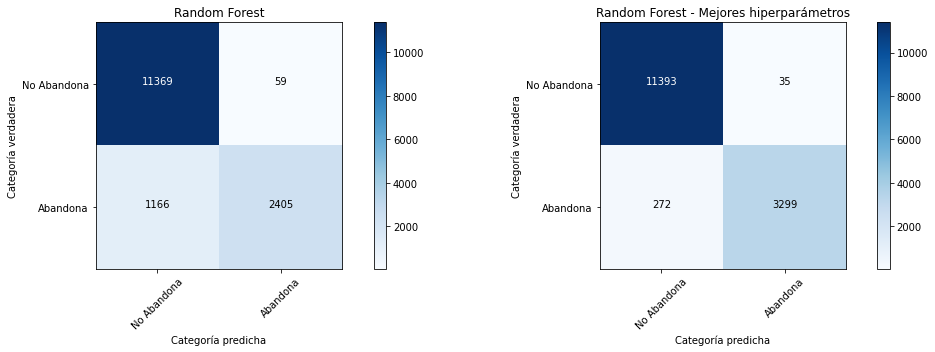

In [17]:
# Comparo las matrices de confusión
plt.figure(figsize=(16, 5))
plt.subplot(121)
plot_confusion_matrix(conf_matrix_rf_1, title="Random Forest")

plt.subplot(122)
plot_confusion_matrix(conf_matrix_rf_2, title="Random Forest - Mejores hiperparámetros")

La nueva matriz de confusión nos idica cuánto de mejor es este nuevo modelo respecto al anterior. Ha cometido muchos menos errores en la clase que más nos interesa.

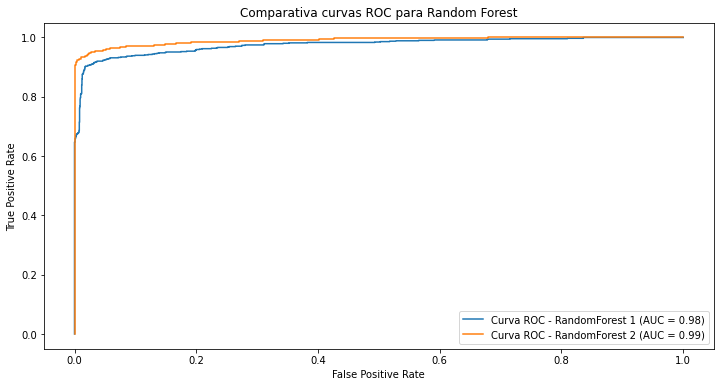

In [18]:
# Curva ROC 


def plot_ROC(clf, title, ax, X_test=X_test, y_test=y_test):
  y_pred_test = clf.predict_proba(X_test)[:,1]

  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)
  roc_auc = metrics.auc(fpr, tpr)
  display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
  display.plot(ax=ax, name=title)
  return roc_auc

fig = plt.figure(figsize=(12 , 6))
ax = ax=plt.subplot(111)
ax.set_title("Comparativa curvas ROC para Random Forest")
auc_rf_1 = plot_ROC(rf_1, title="Curva ROC - RandomForest 1", ax=ax)
auc_rf_2 = plot_ROC(rf_2, title="Curva ROC - RandomForest 2", ax=ax)

El área bajo la curva es parecida en ambos casos. Muy alta.

# Entrenamiento Algoritmo de Boosting

En la primera parte del cuaderno hemos entrenado un algoritmo de *Bagging*.

En esta parte voy a probar con otra aproximación: *Boosting* a ver si conseguimos un mayor poder de predicción.

Seguiremos la misma metodología que en elcaso anterior.

- Primero entrenaremos con un primer conjunto de hiperparámetros que van a estar basados en los del mejor modelo de *Bagging*.
- Luego usaremos una combinación de *RandomSearch* y *GridSearch* para encontrar un segundo conjunto de hiperparámetros.

En este caso también emplearemos la validación cruzada mediante *StratifiedKFold*.

## Primer conjunto de hiperparámetros

In [19]:
# Hiperparámetros de partida.
rf_2.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 201,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [20]:
# Copiamos algunos hiperparámetros del mejor modelo Random Forest
print("Primeros hiperparámetros para Gradient Boosting Clasifier")
print()
params = rf_2.get_params()

n_estimators = params.get("n_estimators")
print("n_estimators:", n_estimators)

max_depth = params.get("max_depth")
print("max_depth:", max_depth)

max_features = params.get("max_features")
print("max_features:", max_features)

min_samples_leaf = params.get("min_samples_leaf")
print("min_samples_leaf:", min_samples_leaf)

min_samples_split = params.get("min_samples_split")
print("min_samples_split:",  min_samples_split)

Primeros hiperparámetros para Gradient Boosting Clasifier

n_estimators: 201
max_depth: 9
max_features: sqrt
min_samples_leaf: 1
min_samples_split: 4


In [21]:
# ENTRENAMIENTO GRADIENT BOOSTING (MISMOS HIPER. QUE RF)
from sklearn.ensemble import GradientBoostingClassifier

gbc_1 = GradientBoostingClassifier(
    random_state=42,
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    # Early stopping para que pare antes si ya no mejora
    validation_fraction=0.2,
    n_iter_no_change=5,
    tol=0.001
)
print("GradientBoostingClassifier #1:", gbc_1)
print()

train_scores_gbc_1 = []
test_scores_gbc_1 = []

start = time.time()
for train_index, test_index in skf.split(X, y):
    X_train = datos.iloc[train_index].loc[:, features]
    X_test = datos.iloc[test_index].loc[:,features]
    y_train = datos.iloc[train_index].loc[:,'left']
    y_test = datos.loc[test_index].loc[:,'left']

    gbc_1.fit(X_train, y_train) #Training the model

    # Save train / test scores
    train_scores_gbc_1.append(gbc_1.score(X_train, y_train))
    test_scores_gbc_1.append(gbc_1.score(X_test, y_test))
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
print()

acc_mean_gbc_1 = np.mean(test_scores_gbc_1)
acc_mean_gbc_1_train = np.mean(train_scores_gbc_1)
print(f"Train score for Gradient Boosting: mean={acc_mean_gbc_1_train:.4f}, std={np.std(train_scores_gbc_1):.6f}")
print(f"Test score for Gradient Boosting: mean={acc_mean_gbc_1:.4f}, std={np.std(test_scores_gbc_1):.6f}")
print()

# Use cross_val_predict to get predicted labels
y_pred_gbc_1 = cross_val_predict(gbc_1, X, y, cv=skf)

# Calculate the bias and variance
bias_gbc_1 = np.abs(y - y_pred_gbc_1).mean()
variance_gbc_1 = acc_mean_gbc_1 - bias_gbc_1
print("Bias:", "%.3f" % bias_gbc_1)
print("Variance:", "%.3f" % variance_gbc_1)
print()

# Print confussion matrix
conf_matrix_gbc_1 = metrics.confusion_matrix(y_true=y, y_pred=y_pred_gbc_1)
print("Confussion Matrix:")
print(conf_matrix_gbc_1)
print()

# Print classification report
clf_report_gbc_1 = metrics.classification_report(y_true=y, y_pred=y_pred_gbc_1)
print("Classification report:")
print(clf_report_gbc_1)
print()

GradientBoostingClassifier #1: GradientBoostingClassifier(max_depth=9, max_features='sqrt',
                           min_samples_split=4, n_estimators=201,
                           n_iter_no_change=5, random_state=42, tol=0.001,
                           validation_fraction=0.2)

Tiempo empleado: 5.68 segundos

Train score for Gradient Boosting: mean=0.9942, std=0.001357
Test score for Gradient Boosting: mean=0.9869, std=0.002537

Bias: 0.013
Variance: 0.974

Confussion Matrix:
[[11386    42]
 [  155  3416]]

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     11428
           1       0.99      0.96      0.97      3571

    accuracy                           0.99     14999
   macro avg       0.99      0.98      0.98     14999
weighted avg       0.99      0.99      0.99     14999




A la vista de esta información, parece que este modelo se comporta igual que *RandomForest*. Esto es esperable ya que ambos modelos se basan en árboles de decisión y se han entrenado con casi los mismos hiperparámetros.

Parece que el tipo de *Ensemble* no influye mucho, en este caso, salvo por el tema de ejecución:

- Random Forest $\sim$ 9s
- Gradien Boosting $\sim$ 5s

Con Gradient Boosting hemos conseguido bajar el tiempo de entrenamiento gracias al *early stopping* que nos permite abortar si vemos que ya no estamos mejorando y no esperarnos a terminar todas las iteraciones.

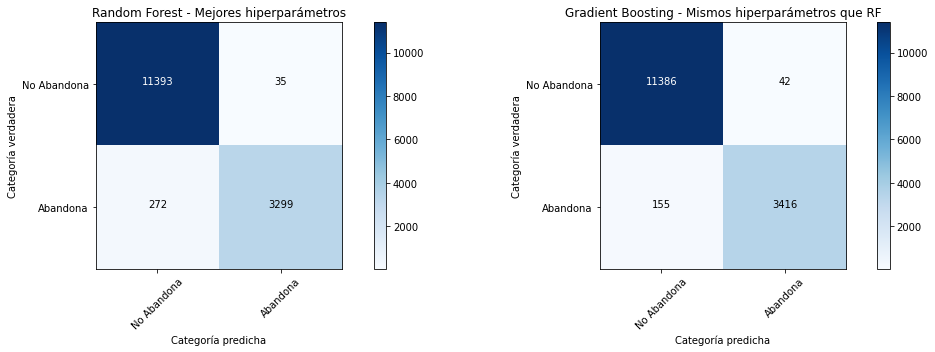

In [22]:
# Comparo las matrices de confusión de Gradient Boosting y Random Forest
plt.figure(figsize=(16, 5))
plt.subplot(121)
plot_confusion_matrix(conf_matrix_rf_2, title="Random Forest - Mejores hiperparámetros")

plt.subplot(122)
plot_confusion_matrix(conf_matrix_gbc_1, title="Gradient Boosting - Mismos hiperparámetros que RF")

Aquí vemos que Gradient Boosting es algo mejor prediciendo la clase que más nos interesa.

## Segundo conjunto de hiperparámetros

En esta sección comprobaremos si podemos encontrar unos hiperparámetros mejores gracias a *RandomSearch* y *GridSearch*.

In [23]:
# BUSCAR LOS MEJORES HIPERPARÁMETROS PARA GRADIENT BOOSTING
# RandomSearch
from sklearn.model_selection import RandomizedSearchCV

max_feat = X.shape[1]
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)],
               'learning_rate': np.linspace(0.1, 0.9, 9),
               'max_features': np.linspace(3, max_feat, round(max_feat / 3),dtype="int"),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

gbc = GradientBoostingClassifier(
    random_state=42,
    # Early stopping para que pare antes si ya no mejora
    validation_fraction=0.2,
    n_iter_no_change=5,
    tol=0.001
)


gbc_random = RandomizedSearchCV(
    estimator = gbc, 
    param_distributions = random_grid, 
    n_iter = 10, 
    cv = skf.split(X, y), 
    verbose=2, 
    random_state=42, 
    n_jobs = -1,
    scoring="accuracy"
)

start = time.time()
gbc_random.fit(X, y)
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
cv_res = gbc_random.cv_results_
print(
    "Accuracy for Gradient Boosting (Random Search):",
    f"mean={cv_res['mean_test_score'].mean():.4f},", 
    f"std={cv_res['std_test_score'].mean():.6f}"
)
gbc_random_best_params = gbc_random.best_params_
gbc_random_best_params

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tiempo empleado: 16.67 segundos
Accuracy for Gradient Boosting (Random Search): mean=0.9753, std=0.002884


{'n_estimators': 573,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 18,
 'learning_rate': 0.5}

In [24]:
# BUSCAR LOS MEJORES HIPERPARÁMETROS PARA RANDOM FOREST
# GridSearch
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
min_samples_leaf = gbc_random_best_params['min_samples_leaf']
min_samples_split = gbc_random_best_params['min_samples_split']
n_estimators = gbc_random_best_params['n_estimators']
learning_rate = gbc_random_best_params['learning_rate']
max_features = gbc_random_best_params['max_features']

param_grid = {
    'max_features': np.arange(max(2, max_features-1), min(18, max_features+2)),
    'min_samples_leaf': np.arange(max(1, min_samples_leaf-1), min_samples_leaf+2),
    'min_samples_split': np.arange(max(2, min_samples_split-1), min_samples_split+2),
    'n_estimators': [
        (n_estimators - 20), (n_estimators - 10), 
        n_estimators, 
        (n_estimators + 10), (n_estimators + 20)],
    'learning_rate': [(learning_rate - 0.1), learning_rate, (learning_rate + 0.1)]
}

# Create a based model
gbc = GradientBoostingClassifier(
    random_state=42,
    # Early stopping para que pare antes si ya no mejora
    validation_fraction=0.2,
    n_iter_no_change=5,
    tol=0.001
)

# Instantiate the grid search model
gbc_grid = GridSearchCV(
    estimator = gbc, 
    param_grid = param_grid, 
    cv = skf.split(X,y), 
    n_jobs = -1, 
    verbose = 2
)
start = time.time()
gbc_grid.fit(X, y)
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
cv_res = gbc_grid.cv_results_
print(
    "Accuracy for Gradient Boosting (Grid Search):",
    f"mean={cv_res['mean_test_score'].mean():.4f},", 
    f"std={cv_res['std_test_score'].mean():.6f}"
)
gbc_grid_best_params = gbc_grid.best_params_
gbc_grid_best_params

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Tiempo empleado: 210.15 segundos
Accuracy for Gradient Boosting (Grid Search): mean=0.9765, std=0.002718


{'learning_rate': 0.4,
 'max_features': 17,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 553}

In [25]:
# ENTRENAMIENTO GRADIENT BOOSTING (MEJORES HIPERPARÁMETROS)
from sklearn.ensemble import GradientBoostingClassifier

gbc_2 = GradientBoostingClassifier(
    random_state=42,
    # Early stopping para que pare antes si ya no mejora
    validation_fraction=0.2,
    n_iter_no_change=5,
    tol=0.001,
    # Hiper parámetros propuestos por Grid Search
    **gbc_grid_best_params
)
print("GradientBoostingClassifier #1:", gbc_2)
print()

train_scores_gbc_2 = []
test_scores_gbc_2 = []

start = time.time()
for train_index, test_index in skf.split(X, y):
    X_train = datos.iloc[train_index].loc[:, features]
    X_test = datos.iloc[test_index].loc[:,features]
    y_train = datos.iloc[train_index].loc[:,'left']
    y_test = datos.loc[test_index].loc[:,'left']

    gbc_2.fit(X_train, y_train) #Training the model

    # Save train / test scores
    train_scores_gbc_2.append(gbc_2.score(X_train, y_train))
    test_scores_gbc_2.append(gbc_2.score(X_test, y_test))
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
print()

acc_mean_gbc_2 = np.mean(test_scores_gbc_2)
acc_mean_gbc_2_train= np.mean(train_scores_gbc_2)
print(f"Train score for Gradient Boosting: mean={acc_mean_gbc_2_train:.4f}, std={np.std(train_scores_gbc_2):.6f}")
print(f"Test score for Gradient Boosting: mean={acc_mean_gbc_2:.4f}, std={np.std(test_scores_gbc_2):.6f}")
print()

# Use cross_val_predict to get predicted labels
y_pred_gbc_2 = cross_val_predict(gbc_2, X, y, cv=skf)

# Calculate the bias and variance
bias_gbc_2 = np.abs(y - y_pred_gbc_2).mean()
variance_gbc_2 = acc_mean_gbc_2 - bias_gbc_2
print("Bias:", "%.3f" % bias_gbc_2)
print("Variance:", "%.3f" % variance_gbc_2)
print()

# Print confussion matrix
conf_matrix_gbc_2 = metrics.confusion_matrix(y_true=y, y_pred=y_pred_gbc_2)
print("Confussion Matrix:")
print(conf_matrix_gbc_2)
print()

# Print classification report
clf_report_gbc_2 = metrics.classification_report(y_true=y, y_pred=y_pred_gbc_2)
print("Classification report:")
print(clf_report_gbc_2)
print()

GradientBoostingClassifier #1: GradientBoostingClassifier(learning_rate=0.4, max_features=17,
                           min_samples_leaf=3, min_samples_split=9,
                           n_estimators=553, n_iter_no_change=5,
                           random_state=42, tol=0.001, validation_fraction=0.2)

Tiempo empleado: 3.35 segundos

Train score for Gradient Boosting: mean=0.9803, std=0.000504
Test score for Gradient Boosting: mean=0.9777, std=0.002946

Bias: 0.022
Variance: 0.955

Confussion Matrix:
[[11319   109]
 [  226  3345]]

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     11428
           1       0.97      0.94      0.95      3571

    accuracy                           0.98     14999
   macro avg       0.97      0.96      0.97     14999
weighted avg       0.98      0.98      0.98     14999




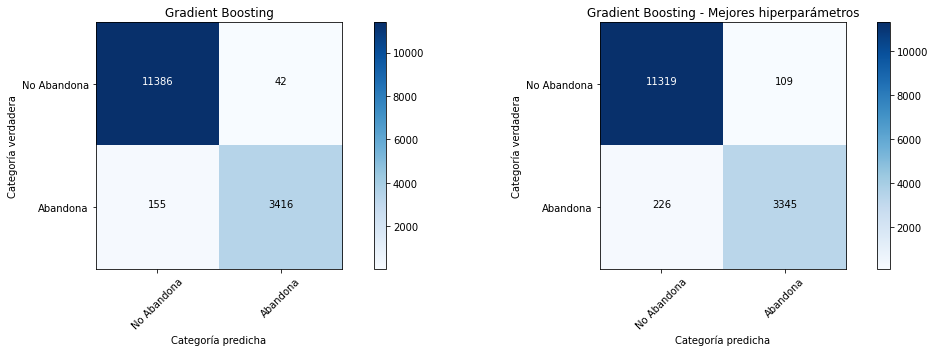

In [26]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plot_confusion_matrix(conf_matrix_gbc_1, title="Gradient Boosting")

plt.subplot(122)
plot_confusion_matrix(conf_matrix_gbc_2, title="Gradient Boosting - Mejores hiperparámetros")

En este caso, el afinado de hiperparámetros no ha funcionado. Debería probar con otras combinaciones y rangos de valores.

No obstante lo dejo así ya que realizar el *Random Search* + *Grid Search* consume bastante tiempo.

Además estamos consiguiendo un buen poder de decisión.

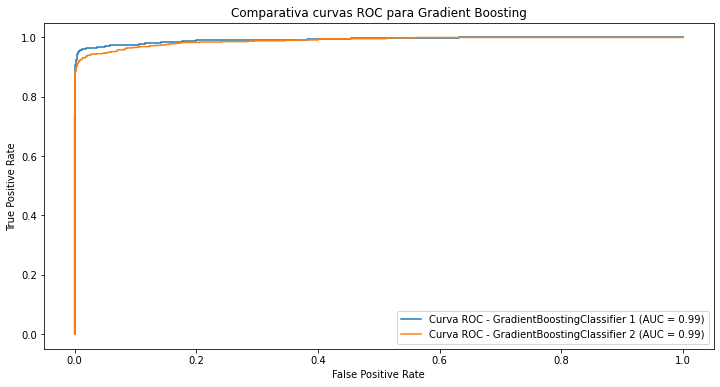

In [27]:
fig = plt.figure(figsize=(12 , 6))
ax = ax=plt.subplot(111)
ax.set_title("Comparativa curvas ROC para Gradient Boosting")
auc_gbc_1 = plot_ROC(gbc_1, title="Curva ROC - GradientBoostingClassifier 1", ax=ax)
auc_gbc_2 = plot_ROC(gbc_2, title="Curva ROC - GradientBoostingClassifier 2", ax=ax)

Las curvas ROC no nos dan mucha más información, ambas son muy similares.

# Entrenar Bagging Classifier con Logistic Regression

En esta sección usaré un *weak learner* diferente a los árboles de decisión.

Me he inclinado por una regresión logística ya que, aunque no me dió un buen resultado en el sprint 1, es relativamente rápido de entrenar.

Con este ejercicio no espero conseguir un gran poder de predicción, pero me puede servir para ver cómo se comporta el *bias* y la *varianza* respecto a los anteriores.

In [28]:
# BÚSQUEDA DE HIPERPARÁMETROS CON GRID SEARCH
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

pip_lr = make_pipeline(StandardScaler(), LogisticRegression(class_weight="balanced"))

bc_lr = BaggingClassifier(base_estimator=pip_lr, random_state=42)


param_grid = {
  'base_estimator__logisticregression__C': np.arange(0.5, 3.0, 0.5),
  'base_estimator__logisticregression__fit_intercept': [True, False],
  'base_estimator__logisticregression__penalty': ['none', 'l2'],
  'n_estimators': np.arange(10, 100, 30),
  'max_samples': np.linspace(0.4, 1.0, 4),
}

bc_lr_grid = GridSearchCV(
    estimator = bc_lr, 
    param_grid = param_grid, 
    cv = skf.split(X,y), 
    n_jobs = -1, 
    verbose = 10
)
start = time.time()
bc_lr_grid.fit(X, y)
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
cv_res = bc_lr_grid.cv_results_
print(
    "Accuracy for Bagging Classifier (Grid Search):",
    f"mean={cv_res['mean_test_score'].mean():.4f},", 
    f"std={cv_res['std_test_score'].mean():.6f}"
)
bc_lr_grid_best_params = bc_lr_grid.best_params_
bc_lr_grid_best_params

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Tiempo empleado: 754.28 segundos
Accuracy for Bagging Classifier (Grid Search): mean=0.7294, std=0.006276


{'base_estimator__logisticregression__C': 0.5,
 'base_estimator__logisticregression__fit_intercept': True,
 'base_estimator__logisticregression__penalty': 'none',
 'max_samples': 0.4,
 'n_estimators': 10}

In [29]:
# ENTRENAR EL BAGGING CLASSIFIER
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


def get_grid_param(name):
  params = bc_lr_grid_best_params
  key_value_list = list(filter(lambda kv: name in kv[0], bc_lr_grid_best_params.items()))
  value = key_value_list[0][1]
  return None if value == 'none' else value

pip_lr = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        class_weight="balanced",
        C=get_grid_param("C"),
        fit_intercept=get_grid_param("fit_intercept"),
        penalty='none'
    )
)
bc_lr = BaggingClassifier(
  base_estimator=pip_lr, 
  random_state=42,
  max_samples=get_grid_param("max_samples"),
  n_estimators=get_grid_param("n_estimators")
)
print(bc_lr)
print()


train_scores_bc_lr = []
test_scores_bc_lr = []

start = time.time()
for train_index, test_index in skf.split(X, y):
    X_train = datos.iloc[train_index].loc[:, features]
    X_test = datos.iloc[test_index].loc[:,features]
    y_train = datos.iloc[train_index].loc[:,'left']
    y_test = datos.loc[test_index].loc[:,'left']

    bc_lr.fit(X_train, y_train) #Training the model

    # Save train / test scores
    train_scores_bc_lr.append(bc_lr.score(X_train, y_train))
    test_scores_bc_lr.append(bc_lr.score(X_test, y_test))
end = time.time()

print(f"Tiempo empleado: {end - start:.2f} segundos")
print()

acc_mean_bc_lr = np.mean(test_scores_bc_lr)
acc_mean_bc_lr_train= np.mean(train_scores_bc_lr)
print(f"Train score for Bagging Classifier: mean={acc_mean_bc_lr_train:.4f}, std={np.std(train_scores_bc_lr):.6f}")
print(f"Test score for Bagging Classifier: mean={acc_mean_bc_lr:.4f}, std={np.std(test_scores_bc_lr):.6f}")
print()

# Use cross_val_predict to get predicted labels
y_pred_bc_lr = cross_val_predict(bc_lr, X, y, cv=skf)

# Calculate the bias and variance
bias_bc_lr = np.abs(y - y_pred_bc_lr).mean()
variance_bc_lr = acc_mean_bc_lr - bias_bc_lr
print("Bias:", "%.3f" % bias_bc_lr)
print("Variance:", "%.3f" % variance_bc_lr)
print()

# Print confussion matrix
conf_matrix_bc_lr = metrics.confusion_matrix(y_true=y, y_pred=y_pred_bc_lr)
print("Confussion Matrix:")
print(conf_matrix_bc_lr)
print()

# Print classification report
clf_report_bc_lr = metrics.classification_report(y_true=y, y_pred=y_pred_bc_lr)
print("Classification report:")
print(clf_report_bc_lr)
print()

BaggingClassifier(base_estimator=Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('logisticregression',
                                                  LogisticRegression(C=0.5,
                                                                     class_weight='balanced',
                                                                     penalty='none'))]),
                  max_samples=0.4, random_state=42)

Tiempo empleado: 2.30 segundos

Train score for Bagging Classifier: mean=0.7604, std=0.001518
Test score for Bagging Classifier: mean=0.7595, std=0.004383

Bias: 0.240
Variance: 0.519

Confussion Matrix:
[[8534 2894]
 [ 713 2858]]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     11428
           1       0.50      0.80      0.61      3571

    accuracy                           0.76     14999
   mac

Lo que más llama la atención es una *precision* del 50% para la clase positiva. 

Esto significa que la probabilidad de que el candidato abandone si este modelo dice que lo hará, es básicamente la misma que si lanzamos una moneda al aire.

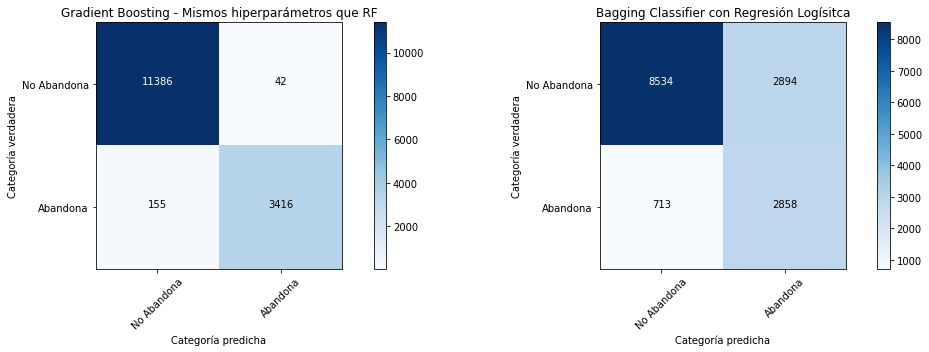

In [30]:
# Comparo la matriz de confusión con la del mejor modelo hasta el momento.

plt.figure(figsize=(16, 5))
plt.subplot(121)
plot_confusion_matrix(conf_matrix_gbc_1, title="Gradient Boosting - Mismos hiperparámetros que RF")

plt.subplot(122)
plot_confusion_matrix(conf_matrix_bc_lr, title="Bagging Classifier con Regresión Logísitca")

Aquí se puede ver que el modelo se ha equivocado bastante más al predecir la clase "Abandona", además del efecto de una *precision* del 50%.

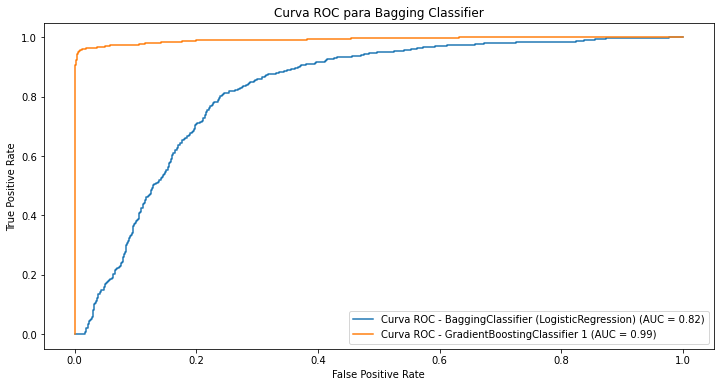

In [31]:
fig = plt.figure(figsize=(12 , 6))
ax = ax=plt.subplot(111)
ax.set_title("Curva ROC para Bagging Classifier")
auc_bc_lr = plot_ROC(bc_lr, title="Curva ROC - BaggingClassifier (LogisticRegression)", ax=ax)
auc_gbc_1 = plot_ROC(gbc_1, title="Curva ROC - GradientBoostingClassifier 1", ax=ax)

Comparando las curvas ROC se puede ver de forma rápida que ese modelo funciona bastante peor que Gradient Boosting.

# Comparar y discutir resultados

In [32]:
# RECOLECCIÓN DE MÉTRICAS
metricas = dict()
metricas["Modelo"] = [
    "RandomForest #1", "RandomForest #2", "GradientBoostingClassifier #1", "GradientBoostingClassifier #2",
    "BaggingClassifier (LogisticRegression)"
]
metricas["Weak Learner"] = [
    "DecissionTreeClassifier", "DecissionTreeClassifier", "DecissionTreeClassifier", 
    "DecissionTreeClassifier", "LogisticRegression"
]
metricas["Accuracy"] = [
    acc_mean_rf_1, acc_mean_rf_2, acc_mean_gbc_1, acc_mean_gbc_2, acc_mean_bc_lr
]
metricas["ROC / AUC"] = [
    auc_rf_1, auc_rf_2, auc_gbc_1, auc_gbc_2, auc_bc_lr
]
metricas["Recall (clase 1)"] = [
    metrics.recall_score(y_true=y, y_pred=y_pred_rf_1),
    metrics.recall_score(y_true=y, y_pred=y_pred_rf_2),
    metrics.recall_score(y_true=y, y_pred=y_pred_gbc_1),
    metrics.recall_score(y_true=y, y_pred=y_pred_gbc_2),
    metrics.recall_score(y_true=y, y_pred=y_pred_bc_lr),
]
metricas["f1-score (clase 1)"] = [
    metrics.f1_score(y_true=y, y_pred=y_pred_rf_1),
    metrics.f1_score(y_true=y, y_pred=y_pred_rf_2),
    metrics.f1_score(y_true=y, y_pred=y_pred_gbc_1),
    metrics.f1_score(y_true=y, y_pred=y_pred_gbc_2),
    metrics.f1_score(y_true=y, y_pred=y_pred_bc_lr)
]
metricas["Bias"] = [
    bias_rf_1, bias_rf_2, bias_gbc_1, bias_gbc_2, bias_bc_lr
]
metricas["Variance"] = [
    variance_rf_1, variance_rf_2, variance_gbc_1, variance_gbc_2, variance_bc_lr
]

df_metricas = pd.DataFrame(metricas)

df_metricas

,Modelo,Weak Learner,Accuracy,ROC / AUC,Recall (clase 1),f1-score (clase 1),Bias,Variance
0,RandomForest #1,DecissionTreeClassifier,0.918328,0.975183,0.673481,0.797017,0.081672,0.836656
1,RandomForest #2,DecissionTreeClassifier,0.979532,0.989955,0.923831,0.955539,0.020468,0.959064
2,GradientBoostingClassifier #1,DecissionTreeClassifier,0.986866,0.992850,0.956595,0.971973,0.013134,0.973731
3,GradientBoostingClassifier #2,DecissionTreeClassifier,0.977665,0.989114,0.936712,0.952313,0.022335,0.955330
4,BaggingClassifier (LogisticRegression),LogisticRegression,0.759517,0.824063,0.800336,0.613107,0.240483,0.519035


## ¿Con qué algoritmo hemos conseguido un mayor poder de predicción?

In [33]:
df_metricas.nlargest(3, "f1-score (clase 1)")

,Modelo,Weak Learner,Accuracy,ROC / AUC,Recall (clase 1),f1-score (clase 1),Bias,Variance
2,GradientBoostingClassifier #1,DecissionTreeClassifier,0.986866,0.992850,0.956595,0.971973,0.013134,0.973731
1,RandomForest #2,DecissionTreeClassifier,0.979532,0.989955,0.923831,0.955539,0.020468,0.959064
3,GradientBoostingClassifier #2,DecissionTreeClassifier,0.977665,0.989114,0.936712,0.952313,0.022335,0.955330


El mayor poder de predicción lo he conseguido con Gradient Boosting usando prácticamente los mismos hiperparámetros que para Random Forest.


## ¿Cómo influye usar un clasificador distinto a los árboles de decisión?

In [34]:
# Comparación del promedio de las métricas
df_metricas.groupby("Weak Learner").mean()

,Accuracy,ROC / AUC,Recall (clase 1),f1-score (clase 1),Bias,Variance
Weak Learner,,,,,,
DecissionTreeClassifier,0.965598,0.986776,0.872655,0.919211,0.034402,0.931195
LogisticRegression,0.759517,0.824063,0.800336,0.613107,0.240483,0.519035


Los *ensembles* basados en árboles de decisión han resultado ser superiores en cuanto a poder de precisión (Accuracy, AUC y f1-score).

Los árboles de decisión han demostrado tener **menor sesgo (bias)** y **mayor varianza** que la regresión logística.

- Un sesgo (bias) más alto puede indicar que los datos no cumplen ciertas condiciones que supone el modelo. Las regresiones dan por supuesto que las variables explicativas son independientes entre sí. En cambio los árboles de decisión no se ven afectados por esto.
- Una varianza más alta, indica que quizás los árboles de decisión hayan resultado demasiado sensibles a este conjunto de datos y probablemente se comporten peor con datos nuevos.


# Obtención de las variables más relevantes del modelo.

Nos vamos a basar en el mejor modelo del ejercicio: `GradientBoostingClassifier #1`

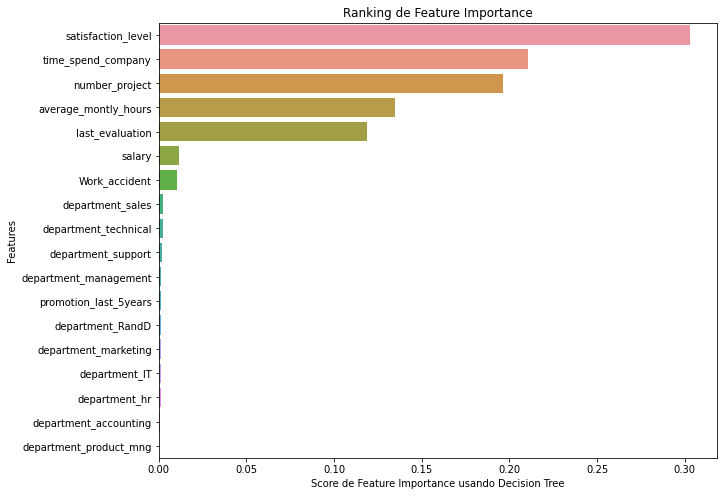

In [35]:
plt.figure(figsize=(10,8))

feature_imp=pd.Series(gbc_1.feature_importances_,
index=list(features)).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score de Feature Importance usando Decision Tree')
plt.ylabel('Features')
plt.title("Ranking de Feature Importance")

plt.show()

## ¿Tiene sentido que sean las variables con más peso?

Si definimos el peso como **en qué medida influye la variable en que el candidato tome una decisión u otra**, las variables con más importancia sí que serían las variables con mayor peso.

Aprovechando que hemos entrenado una regresión logística podemos extraer los pesos de los coeficientes de la regresión.

In [36]:
# Extraemos los coeficientes e la regresión (pesos)
coef_list = [estimator["logisticregression"].coef_ for estimator in bc_lr.estimators_]
coef_list = np.array([a[0,:] for a in coef_list])

feature_weights = coef_list.mean(axis=0)
print(feature_weights.shape)

(18,)


In [37]:
# Relevancia de las variables
feature_importances = gbc_1.feature_importances_
feature_importances.shape

(18,)

In [38]:
# Cargamos ambas dimensiones en un dataframe
df = df = pd.DataFrame({
    "importance": gbc_1.feature_importances_,
    "weight": feature_weights
})
df.shape

(18, 2)

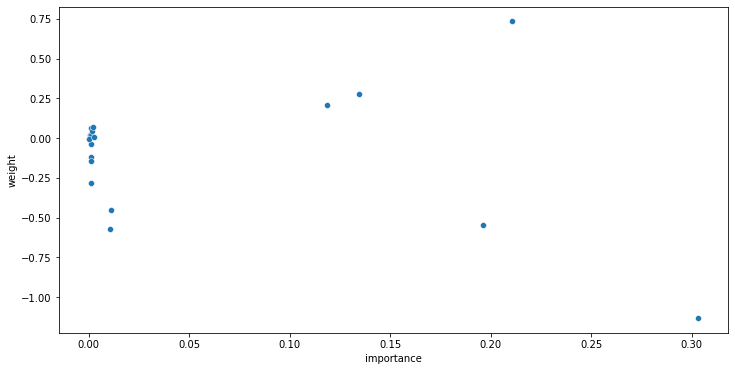

In [40]:
# Comparamos ambas en un gráfico de dispersión
fig = plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x="importance", y="weight")
plt.show()

Aparentemente los pesos que le ha dado la regresión logística a cada variable no se corresponde con la importancia que le ha dado el árbol de regresión. En este gráfico no se detecta ningún patrón.

In [41]:
# Mostramos los coeficientes de correlación
df.corr()

,importance,weight
importance,1.000000,-0.222603
weight,-0.222603,1.000000


En cambio sí que hay una ligera correlación inversa. Cuanto mayor es el peso que le otorga la regresión, menor es la importancia que le da a la variable el árbol de regresión.

Recordemos que el sesgo (bias) obtenido con los árboles de decisión es mayor que con la regresión logística. Por lo tanto, es posible que sean más fiables los pesos (regresión) que las importancias (árboles de decisión).